In [10]:
import pandas as pd
import numpy as np
import os

from gene_variation_effects import config
from gene_variation_effects.modeling import NNPipeLine, MLP, data_shuffle_split, run_training_loop, test_model
import torch
import matplotlib.pyplot as plt

from pyliftover import LiftOver

import json

seed = 42
TARGET_GENE = "BRCA1"
df = None

In [11]:
DATASET_NAME = 'dataset.csv'
TARGET_FEATURE = 'ClinSigSimple'
df = pd.read_csv(os.path.join(config.DATA_DIR, DATASET_NAME))
df = df[df["GeneSymbol"] == TARGET_GENE]
df.to_csv(os.path.join(config.DATA_DIR, f"{TARGET_GENE}.csv"))

sequence_file = os.path.join(config.DATA_DIR, f"{TARGET_GENE}_seq.txt")
misc_BRCA1_file = os.path.join(config.DATA_DIR, f"{TARGET_GENE}.json")
with open(sequence_file, 'r') as file:
    sequence = file.read()
gene_sequence_length = len(sequence)
print(gene_sequence_length)

with open(misc_BRCA1_file, 'r') as file:
    misc_data = json.load(file)
gene_start_position = misc_data['start']
gene_end_position = misc_data['end']
chromosome = misc_data['seq_region_name']

gene_start_position = 43044292
gene_end_position = 43170245
lo = LiftOver('hg38', 'hg19')  # GRCh38 -> GRCh37, The ClinVar data is a bit older so it uses GRCh37
conv_start = lo.convert_coordinate('chr17', gene_start_position)[0][1]
conv_end = lo.convert_coordinate('chr17', gene_end_position)[0][1]

gene_sequence_length = conv_end - conv_start + 1

# Convert start into relative positon
df['RelativeStart'] = np.where(df['Start'] <= conv_end, df['Start'] - conv_start, df['Start'] - gene_start_position) / gene_sequence_length
df.drop(columns=['Start'], inplace=True)


# df.drop(columns=['Start'], inplace=True)

125954


In [12]:
if df is None:
    df = pd.read_csv(os.path.join(config.DATA_DIR, f"{TARGET_GENE}.csv"))

target_array = df[TARGET_FEATURE]
df.drop(columns=[TARGET_FEATURE, "GeneSymbol"], inplace=True)
ONEHOT_FEATURES = ['Type']
EMBEDDED_FEATURES = []
NUMERIC_FEATURES = ['VariantLength', 'VariantLengthDifference', 'RelativeStart']
pipeline = NNPipeLine(df.columns, ONEHOT_FEATURES, EMBEDDED_FEATURES, NUMERIC_FEATURES)

In [13]:
# Split the data
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2
training_data, validation_data, test_data, training_target_array, validation_target_array, test_target_array = \
    data_shuffle_split(df.to_numpy(), target_array, TEST_SIZE, VALIDATION_SIZE, seed)

In [14]:
# Fit pipeline and transform data
# TODO: See why astype is needed here
transformed_X_training, feature_processor = pipeline.fit_feature_transformations(training_data)
transformed_X_training = torch.Tensor(transformed_X_training)
transformed_X_validation = torch.Tensor(feature_processor.transform(validation_data))
transformed_X_test = torch.Tensor(feature_processor.transform(test_data))

training_target_array = torch.unsqueeze(torch.Tensor(training_target_array.to_numpy()), 1)
validation_target_array =  torch.unsqueeze(torch.Tensor(validation_target_array.to_numpy()), 1)
test_target_array =  torch.unsqueeze(torch.Tensor(test_target_array.to_numpy()), 1)

In [15]:
# We only have one embedding input size right now, since we're doing this by hand anyways we can probably hard-code each one
# going forward. Maybe there is a way to automate this.
HIDDEN_SIZES = [128, 64]
DROPOUT = 0.1
embedding_dimension_mapping = np.array([])
model = MLP(embedding_dimension_mapping, HIDDEN_SIZES, transformed_X_training.shape[1], DROPOUT)

2025-11-01 22:15:30.683 | INFO     | gene_variation_effects.modeling.train:run_training_loop:91 - Epoch 1: accuracy=0.6250
2025-11-01 22:15:30.683 | INFO     | gene_variation_effects.modeling.train:run_training_loop:92 - Epoch 1: validation accuracy=0.7344
2025-11-01 22:15:30.683 | INFO     | gene_variation_effects.modeling.train:run_training_loop:93 - Epoch 1: validation loss=1.3683
2025-11-01 22:15:30.684 | INFO     | gene_variation_effects.modeling.train:run_training_loop:91 - Epoch 2: accuracy=0.6562
2025-11-01 22:15:30.684 | INFO     | gene_variation_effects.modeling.train:run_training_loop:92 - Epoch 2: validation accuracy=0.7812
2025-11-01 22:15:30.684 | INFO     | gene_variation_effects.modeling.train:run_training_loop:93 - Epoch 2: validation loss=1.3422
2025-11-01 22:15:30.685 | INFO     | gene_variation_effects.modeling.train:run_training_loop:91 - Epoch 3: accuracy=0.5938
2025-11-01 22:15:30.685 | INFO     | gene_variation_effects.modeling.train:run_training_loop:92 - Epoch

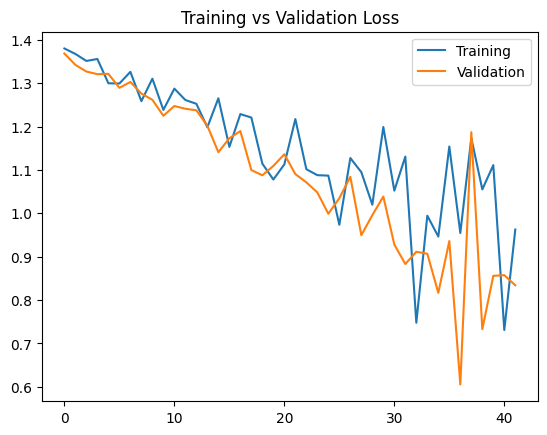

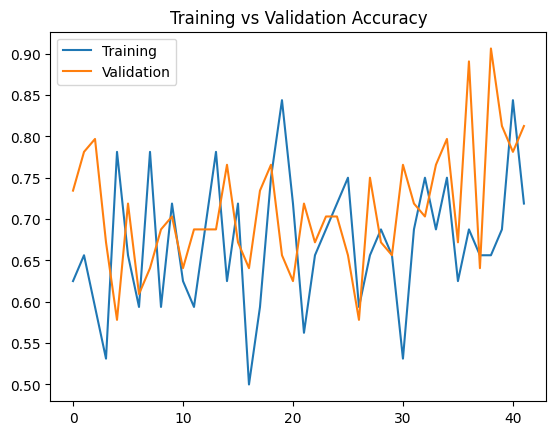

<Figure size 640x480 with 0 Axes>

In [16]:
# Get indices for columns using embedding
features_indices = {feat: i for i, feat in enumerate(feature_processor.get_feature_names_out())}
embedding_features_indices = [ind for feat, ind in features_indices.items() if feat.startswith('high_cardinality')]
BATCH_SIZE = 32
PATIENCE = 5

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
optimal_model_dict, training_losses, val_losses, training_accuracies, val_accuracies = run_training_loop(
    model, BATCH_SIZE, transformed_X_training, transformed_X_validation, training_target_array, validation_target_array, embedding_features_indices, patience=PATIENCE, 
    optimizer=optimizer)
torch.save(optimal_model_dict, f"../models/{TARGET_GENE}model.pth")


plt.plot(training_losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()
plt.clf()

plt.plot(training_accuracies, label="Training")
plt.plot(val_accuracies, label="Validation")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()
plt.clf()

In [17]:
# Recreate the model structure
model.load_state_dict(torch.load(f"../models/{TARGET_GENE}model.pth"))

<All keys matched successfully>

In [18]:
avg_loss, accuracy = test_model(model, BATCH_SIZE, transformed_X_test, test_target_array, embedding_features_indices)
avg_loss, accuracy

(0.40536294543204465, tensor(0.8656))